In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix,\
    accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT

In [2]:
df = pd.read_csv('dataset.csv')

activities_labels = ['STANDING', 'LAYING', 'SITTING', 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
transitions_labels = ['SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_SIT', 'SIT_TO_STAND']

# Filter
df = df.loc[~df['Activity'].isin(['LIE_TO_STAND', 'STAND_TO_LIE'])]

X = df.drop(columns=['Activity'])
y = df['Activity']

metrics = ['f1_weighted', 'balanced_accuracy', 'accuracy']

In [3]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

## KNN removing some PT

In [4]:

class_hierarchy = {
    ROOT: ["T", "NT"],
    "NT": activities_labels,
    "T": transitions_labels
}

base_estimator = {
    ROOT: SVC(C=100, kernel='rbf', probability=True, random_state=42),
    "NT": MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 500,
                    hidden_layer_sizes=(400,),
                    random_state=42),
    "T": KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
}

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    prediction_depth='mlnp',
    algorithm='lcpn',
)

In [5]:
result = cross_validate(clf, X, y, cv=10, scoring=metrics,
                        return_train_score=True, n_jobs=-1)

print("\tf1:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
    .format(mean = result.get('test_f1_weighted').mean()*100,
            std = result.get('test_f1_weighted').std()))

print("\tbalanced accuracy:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
    .format(mean = result.get('test_balanced_accuracy').mean()*100,
            std = result.get('test_balanced_accuracy').std()))

print("\taccuracy:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
      .format(mean = result.get('test_accuracy').mean()*100,
              std = result.get('test_accuracy').std()))

	f1:
		mean = 95.46%;
		std = 0.03;
	balanced accuracy:
		mean = 94.44%;
		std = 0.03;
	accuracy:
		mean = 95.49%;
		std = 0.03;


In [6]:
acc = cross_val_score(clf, X=X, y=y, cv=10,
                      scoring=make_scorer(
                          classification_report_with_accuracy_score
                      ))

print("Accuracy")
print("mean = {mean:.2f}%;\tstd = {std:.2f};"
      .format(mean = acc.mean()*100,
              std = acc.std()))

# Average values in classification report for all folds in a K-fold Cross-validation
print(classification_report(originalclass, predictedclass))

Accuracy
mean = 95.49%;	std = 0.03;
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00      1958
        LIE_TO_SIT       0.98      0.98      0.98        85
           SITTING       0.93      0.93      0.93      1801
        SIT_TO_LIE       0.95      0.93      0.94       107
      SIT_TO_STAND       0.87      1.00      0.93        33
          STANDING       0.95      0.93      0.94      1979
      STAND_TO_SIT       0.92      0.80      0.85        70
           WALKING       0.97      0.95      0.96      1722
WALKING_DOWNSTAIRS       0.94      0.98      0.96      1407
  WALKING_UPSTAIRS       0.94      0.94      0.94      1544

          accuracy                           0.95     10706
         macro avg       0.94      0.94      0.94     10706
      weighted avg       0.96      0.95      0.95     10706



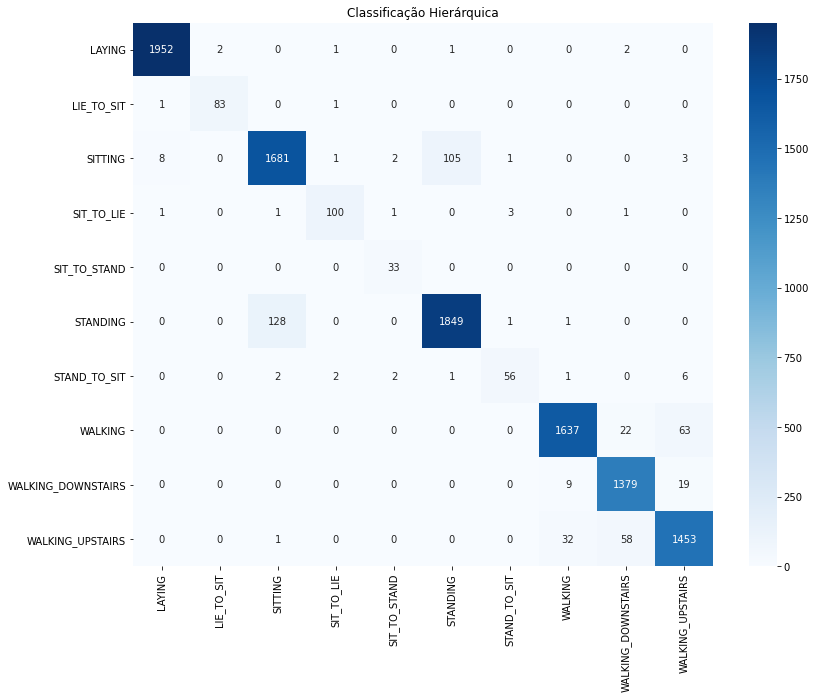

In [7]:
cf_matrix = confusion_matrix(originalclass, predictedclass)

categories = np.unique(y).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Hierárquica')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)
